In [1]:
import glob
import numpy as np
import math
import pandas as pd

path = 'C:/Users/ardak/VED_DynamicData_Part1/*.csv' #path değiştirilmeli

filenames = glob.glob(path)

VED_data = pd.read_csv(filenames[1])
trips = VED_data.iloc[:, 2].unique().tolist()

init = np.empty(1)
final = np.empty(1)
for i in trips:         # to find the initial and final locations of all trips
    position_latitude = VED_data.loc[VED_data['Trip'] == i].iloc[:, 4].values
    position_longitude = VED_data.loc[VED_data['Trip'] == i].iloc[:, 5].values
    init = np.concatenate((init,np.array([position_latitude[0], position_longitude[0]])),axis = 0)
    final = np.concatenate((final,np.array([position_latitude[-1], position_longitude[-1]])),axis = 0)
final = np.delete(final,0)
init = np.delete(init,0)
trips = np.array(trips)
init_pos = np.reshape(init,(-1,2))
final_pos = np.reshape(final,(-1,2))
data_trip_dict = {'Trip ID':trips ,'Initial Position Latitude':init_pos[:,0],'Initial Position Longitude':init_pos[:,1],'Final Position Latitude':final_pos[:,0],'Final Position Longitude':final_pos[:,1] }               # converges all lists into one

trip_data = pd.DataFrame(data_trip_dict)

ref_point_lat = (trip_data['Initial Position Latitude'].mean()+trip_data['Final Position Latitude'].mean())/2
ref_point_long = (trip_data['Initial Position Longitude'].mean()+trip_data['Final Position Longitude'].mean())/2
ref_point = (ref_point_lat, ref_point_long)


def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

trip_data['Init_to_ref'] = 0
trip_data['Final_to_ref'] = 0
trip_data = trip_data.astype({'Init_to_ref': float,'Final_to_ref':float}) 
for i in range(len(trip_data)):
    trip_data.at[i, 'Init_to_ref'] = distance(ref_point, (trip_data['Initial Position Latitude'][i],trip_data['Initial Position Longitude'][i]))
    trip_data.at[i, 'Final_to_ref'] = distance(ref_point, (trip_data['Final Position Latitude'][i],trip_data['Final Position Longitude'][i]))
    
    

trip_data.head()

,Trip ID,Initial Position Latitude,Initial Position Longitude,Final Position Latitude,Final Position Longitude,Init_to_ref,Final_to_ref
0,1625,42.287548,-83.719066,42.281762,-83.750967,1.934505,2.277806
1,2604,42.274841,-83.734721,42.278180,-83.746008,0.736234,1.728148
2,2609,42.229736,-83.725925,42.278527,-83.739710,4.615208,1.309285
3,1335,42.244127,-83.765051,42.267869,-83.771118,4.333078,3.631265
4,644,42.285025,-83.802222,42.228655,-83.778681,6.358309,6.352388


In [2]:
Vehicles = VED_data['VehId'].unique()
ntrips = np.ndarray(1)
for i in Vehicles:
    trip_nums = VED_data['Trip'].loc[VED_data['VehId'] == i].unique().size
    ntrips = np.append(ntrips,trip_nums)
ntrips = np.delete(ntrips,0)
trips_peruser = pd.DataFrame({'VehId': Vehicles, '# of Trips':ntrips})
print(trips_peruser)

     VehId  # of Trips
0       10         4.0
1      116        11.0
2      125         4.0
3      128         4.0
4      130        11.0
..     ...         ...
252    315         1.0
253    429         1.0
254    431         1.0
255    526         1.0
256    607         1.0

[257 rows x 2 columns]


Her vehicle=user, her userın toplam trip sayısını buldum.

Trip toplam uzunluğu için her t ve t-1 arasındaki uzaklığı bulup toplayabilirim.

In [3]:
trip_lens = np.ndarray(1)
for t in trips:
    position_latitude = VED_data.loc[VED_data['Trip'] == t].iloc[:, 4].values
    position_longitude = VED_data.loc[VED_data['Trip'] == t].iloc[:, 5].values
    x = 0
    for i in range(position_latitude.size): 
        if position_latitude[i]==position_latitude[-1]:
            break 
        x = x + distance((position_latitude[i],position_longitude[i]),(position_latitude[i+1],position_longitude[i+1]))
    trip_lens = np.append(trip_lens,x)
trip_lens = np.delete(trip_lens,0)
trip_len_data = pd.DataFrame({'Trip':trips,'Length of Trip':trip_lens})

In [4]:
trip_len_data

,Trip,Length of Trip
0,1625,3.039582
1,2604,1.525499
2,2609,6.672108
3,1335,4.620591
4,644,14.252835
...,...,...
676,258,6.606538
677,700,3.656814
678,274,5.318664
679,284,6.292663


In [5]:
VED_data.head()

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Air Conditioning Power[kW],Air Conditioning Power[Watts],Heater Power[Watts],HV Battery Current[A],HV Battery SOC[%],HV Battery Voltage[V],Short Term Fuel Trim Bank 1[%],Short Term Fuel Trim Bank 2[%],Long Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 2[%]
0,15.85402,10,1625,0,42.287548,-83.719066,36.130001,NaN,NaN,NaN,...,NaN,350.0,0.0,-59.0,61.707321,371.0,NaN,NaN,NaN,NaN
1,15.85402,10,1625,100,42.287548,-83.719066,40.919998,NaN,NaN,NaN,...,NaN,350.0,0.0,-59.0,61.707321,371.0,NaN,NaN,NaN,NaN
2,15.85402,10,1625,300,42.287548,-83.719066,40.919998,NaN,NaN,NaN,...,NaN,350.0,0.0,-58.5,61.707321,371.0,NaN,NaN,NaN,NaN
3,15.85402,10,1625,1100,42.287548,-83.719066,44.529999,NaN,NaN,NaN,...,NaN,350.0,0.0,-58.5,61.707321,371.0,NaN,NaN,NaN,NaN
4,15.85402,10,1625,1300,42.287548,-83.719066,44.529999,NaN,NaN,NaN,...,NaN,350.0,0.0,-50.0,61.707321,371.0,NaN,NaN,NaN,NaN


BAK: Raw data nasıl incelenir.


In [6]:
trip_len_data.loc[trip_len_data['Length of Trip'] == trip_len_data['Length of Trip'].min()]

,Trip,Length of Trip
591,821,0.191577


In [7]:
trip_len_data.describe()

,Trip,Length of Trip
count,681.000000,681.000000
mean,867.346549,8.514255
std,481.262116,8.663567
min,14.000000,0.191577
25%,536.000000,2.834249
50%,827.000000,5.840479
75%,1152.000000,11.434037
max,2660.000000,71.095651


In [11]:
import matplotlib.pyplot as plt

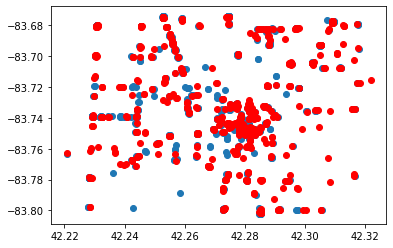

In [12]:
plt.scatter(x = trip_data['Initial Position Latitude'],y = trip_data['Initial Position Longitude'],label = 'Initial')
plt.scatter(x = trip_data['Final Position Latitude'],y = trip_data['Final Position Longitude'], color='r',label = 'Final')

In [13]:
trip_data.head()

,Trip ID,Initial Position Latitude,Initial Position Longitude,Final Position Latitude,Final Position Longitude,Init_to_ref,Final_to_ref
0,1625,42.287548,-83.719066,42.281762,-83.750967,1.934505,2.277806
1,2604,42.274841,-83.734721,42.278180,-83.746008,0.736234,1.728148
2,2609,42.229736,-83.725925,42.278527,-83.739710,4.615208,1.309285
3,1335,42.244127,-83.765051,42.267869,-83.771118,4.333078,3.631265
4,644,42.285025,-83.802222,42.228655,-83.778681,6.358309,6.352388


In [19]:
from scipy import stats

In [21]:
trip_len_data['Z score'] = stats.zscore(trip_len_data['Length of Trip'])

In [22]:
trip_len_data.head()

,Trip,Length of Trip,Z score
0,1625,3.039582,-0.632384
1,2604,1.525499,-0.807276
2,2609,6.672108,-0.212788
3,1335,4.620591,-0.449760
4,644,14.252835,0.662868


,Trip,Length of Trip,Z score
count,604.000000,604.000000,604.000000
mean,877.723510,6.152723,-0.272782
std,495.895506,4.369703,0.504748
min,14.000000,0.191577,-0.961359
25%,528.750000,2.518062,-0.692625
50%,826.000000,5.071278,-0.397701
75%,1167.750000,9.001113,0.056237
max,2660.000000,17.099136,0.991646


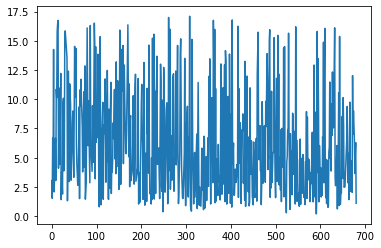

In [38]:
trip_len_data_clean1 = trip_len_data.loc[trip_len_data['Z score'].abs()<=1]
trip_len_data_clean1['Length of Trip'].plot()
trip_len_data_clean1.describe()

Z score = (x-mean)/std , abs değerlerinin hangi aralıkta olacağını değiştirerek filtreleyebilirim.

,Trip,Length of Trip,Z score
count,420.000000,420.000000,420.000000
mean,875.676190,6.909035,-0.185420
std,463.661797,3.273440,0.378118
min,30.000000,2.471983,-0.697947
25%,551.750000,4.277279,-0.489416
50%,832.000000,6.209671,-0.266204
75%,1163.250000,9.389242,0.101070
max,2648.000000,14.523781,0.694165


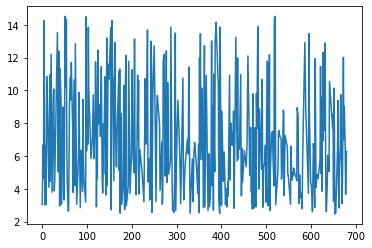

In [40]:
trip_len_data_clean2 = trip_len_data.loc[trip_len_data['Z score'].abs()<=0.7]
trip_len_data_clean2['Length of Trip'].plot()
trip_len_data_clean2.describe()